In [1]:
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from PIL import Image, ImageDraw, ImageFont
import numpy as np
from sklearn.model_selection import train_test_split
import imgkit
import easyocr
import torchvision.transforms as T
from pathlib import Path
import matplotlib.pyplot as plt
import os
import cv2
from typing import List
import json
from torchmetrics import Accuracy
from huggingface_hub import notebook_login
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline
pl.seed_everything(42)

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Global seed set to 42


42

In [2]:
image_paths = sorted(list(Path("images").glob("*/*.jpg")))

## Preprocessing

In [3]:
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False)
tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

/opt/conda/lib/python3.7/site-packages/transformers/models/layoutlmv3/feature_extraction_layoutlmv3.py:33: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  FutureWarning,


In [4]:
image_path = image_paths[0]
image = Image.open(image_path).convert("RGB")
width, height = image.size
width, height

(819, 1195)

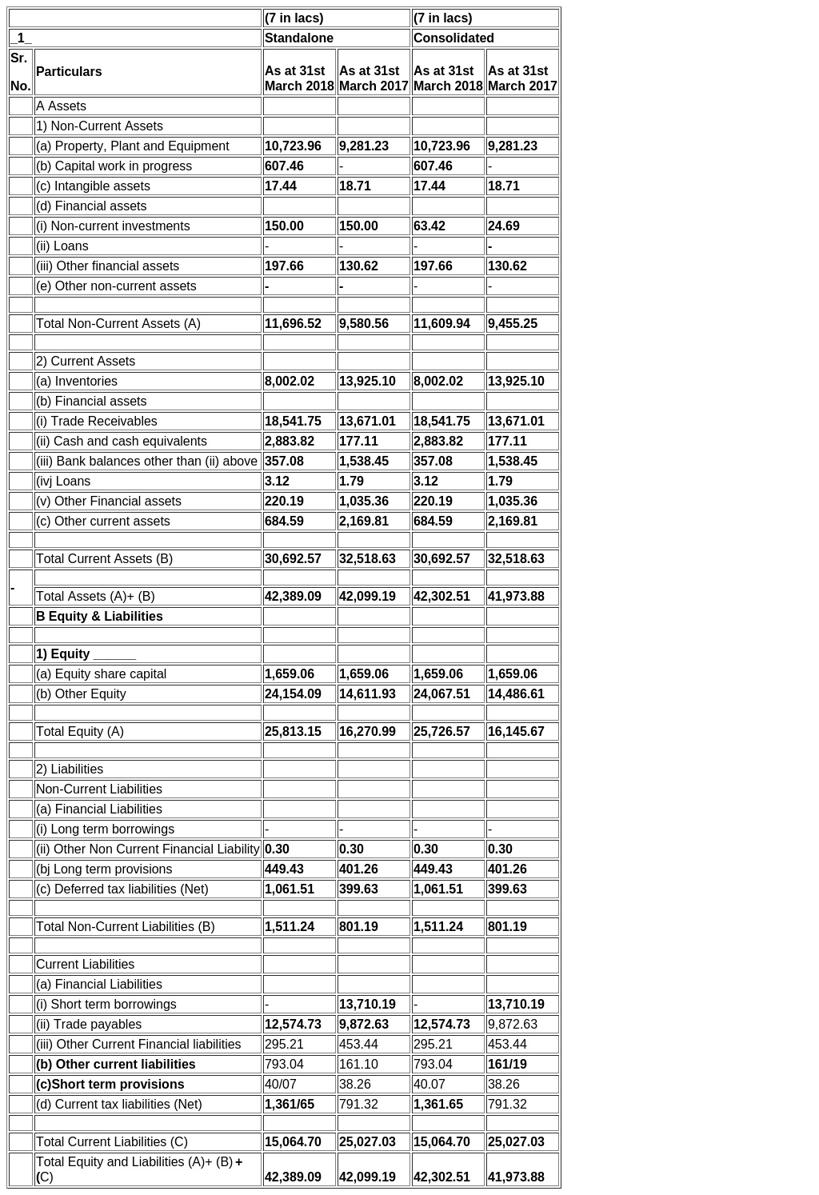

In [5]:
image

In [6]:
# it is done to scale the width and  the height 
width_scale = 1000 / width
height_scale = 1000 / height

width_scale, height_scale

(1.221001221001221, 0.8368200836820083)

In [7]:
json_path = image_path.with_suffix(".json")
json_path

PosixPath('images/balance_sheets/18320959_3.json')

In [8]:
with json_path.open("r") as f:
    ocr_result = json.load(f)

In [9]:
# as we have to scale the images, so the bounding boxes scale in that ratio too 
def scale_bounding_box(box: List[int], width_scale : float = 1.0, height_scale : float = 1.0) -> List[int]:
    return [
        int(box[0] * width_scale),
        int(box[1] * height_scale),
        int(box[2] * width_scale),
        int(box[3] * height_scale)
    ]

In [10]:
words = []
boxes = []
for row in ocr_result:
    boxes.append(scale_bounding_box(row["bounding_box"], width_scale, height_scale))
    words.append(row["word"])

## Encoding

In [11]:
encoding = processor(
    image,
    words,
    boxes=boxes,
    max_length=512,
    padding="max_length",
    truncation=True,
    return_tensors="pt"
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask', 'bbox', 'pixel_values'])

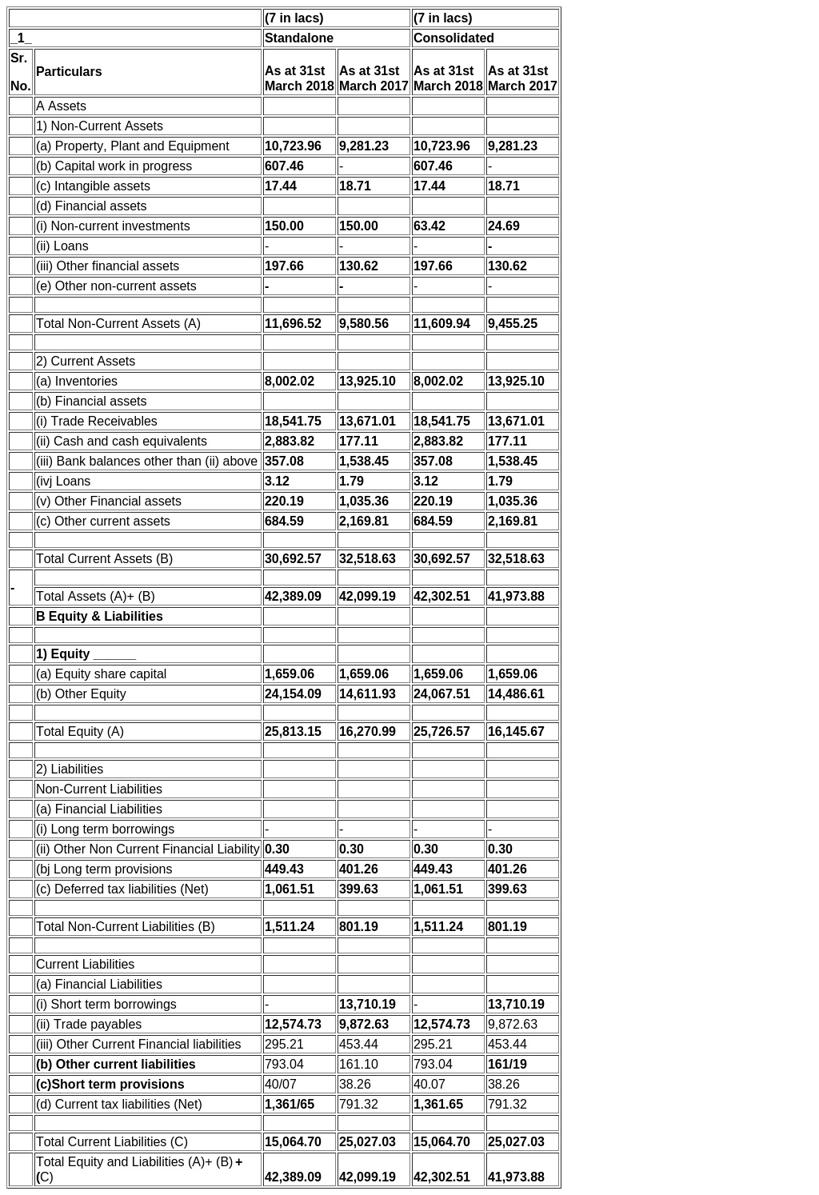

In [12]:
image

In [13]:
print(f"""
input_ids:  {list(encoding["input_ids"].squeeze().shape)}
word boxes: {list(encoding["bbox"].squeeze().shape)}
image data: {list(encoding["pixel_values"].squeeze().shape)}
image size: {image.size}
""")


input_ids:  [512]
word boxes: [512, 4]
image data: [3, 224, 224]
image size: (819, 1195)



In [14]:
image_data = encoding["pixel_values"][0]
image_data.shape

torch.Size([3, 224, 224])

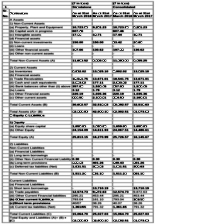

In [15]:
transform = T.ToPILImage()
transform(image_data)

## Dataset

In [16]:
train_images, test_images = train_test_split(image_paths, test_size=.2)

In [17]:
DOCUMENT_CLASSES = sorted(list(map(lambda p: p.name, Path("images").glob("*"))))
DOCUMENT_CLASSES

['balance_sheets', 'cash_flow', 'income_statement', 'notes', 'others']

In [18]:
image_path = image_paths[300]
print(image_path)
DOCUMENT_CLASSES.index(image_path.parent.name)

images/cash_flow/18661965_table_39.jpg


1

In [19]:
class DocumentClassificationDataset(Dataset):

    def __init__(self, image_paths, processor):
        self.image_paths = image_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, item):

        image_path = self.image_paths[item]
        json_path = image_path.with_suffix(".json")
        with json_path.open("r") as f:
            ocr_result = json.load(f)
            # we do the same things we did 
            with Image.open(image_path).convert("RGB") as image:

                width, height = image.size
                width_scale = 1000 / width
                height_scale = 1000 / height

                words = []
                boxes = []
                for row in ocr_result:
                    boxes.append(scale_bounding_box(row["bounding_box"], width_scale, height_scale))
                    words.append(row["word"])

                encoding = self.processor(
                    image,
                    words,
                    boxes=boxes,
                    max_length=512,
                    padding="max_length",
                    truncation=True,
                    return_tensors="pt"
                )

        label = DOCUMENT_CLASSES.index(image_path.parent.name)

        return dict(
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            bbox=encoding["bbox"].flatten(end_dim=1),
            pixel_values=encoding["pixel_values"].flatten(end_dim=1),
            labels=torch.tensor(label, dtype=torch.long)
        )

In [20]:
train_dataset = DocumentClassificationDataset(train_images, processor)
test_dataset = DocumentClassificationDataset(test_images, processor)

In [21]:
for item in train_dataset:
    print(item["bbox"].shape)
    print(item["pixel_values"].shape)
    print(item["labels"].shape)
    break

torch.Size([512, 4])
torch.Size([3, 224, 224])
torch.Size([])


In [22]:
# Shuff true for training
train_data_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2
)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=2
)

## Model

In [23]:
model = LayoutLMv3ForSequenceClassification.from_pretrained("microsoft/layoutlmv3-base", num_labels=2)

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
class ModelModule(pl.LightningModule):
    def __init__(self, n_classes:int):
        super().__init__()
        self.model = LayoutLMv3ForSequenceClassification.from_pretrained(
            "microsoft/layoutlmv3-base",
            num_labels=n_classes
        )
        self.model.config.id2label = {k: v for k, v in enumerate(DOCUMENT_CLASSES)}
        self.model.config.label2id = {v: k for k, v in enumerate(DOCUMENT_CLASSES)}
        self.train_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=n_classes)

    def forward(self, input_ids, attention_mask, bbox, pixel_values, labels=None):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            bbox=bbox,
            pixel_values=pixel_values,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("train_loss", output.loss)
        self.log("train_acc", self.train_accuracy(output.logits, labels), on_step=True, on_epoch=True)
        return output.loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("val_loss", output.loss)
        self.log("val_acc", self.val_accuracy(output.logits, labels), on_step=False, on_epoch=True)
        return output.loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.00001) #1e-5
        return optimizer

In [25]:
model_module = ModelModule(len(DOCUMENT_CLASSES))

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model_checkpoint = ModelCheckpoint(
    filename="{epoch}-{step}-{val_loss:.4f}", save_last=True, save_top_k=3, monitor="val_loss", mode="min"
)

trainer = pl.Trainer(
    accelerator="gpu",
    precision=16,
    devices=1,
    max_epochs=1,
    callbacks=[
        model_checkpoint
    ],
)

Using 16bit None Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model_module, train_data_loader, test_data_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                                | Params
-----------------------------------------------------------------------
0 | model          | LayoutLMv3ForSequenceClassification | 125 M 
1 | train_accuracy | MulticlassAccuracy                  | 0     
2 | val_accuracy   | MulticlassAccuracy                  | 0     
-----------------------------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
251.843   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:229: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
model_checkpoint.best_model_path

In [ ]:
trained_model = ModelModule.load_from_checkpoint(
    model_checkpoint.best_model_path,
    n_classes=len(DOCUMENT_CLASSES),
    local_files_only=True
)

In [ ]:
trained_model.model.save_pretrained(Path("best-model"))

In [ ]:
notebook_login()

In [ ]:
trained_model.model.push_to_hub("layoutlmv3-fdc")